# Supplementary Jupyter notebook

This notebook demonstrate use of Python [APSG package](https://github.com/ondrolexa/apsg) for calculations presented in the submitted manuscript Miao et al.


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from apsg import *

Deformation $D_2$ is simulated as coaxial shortening in Y direction accompanied by active folding and flattening with amplification in Z direction. Folding is simulated by parabolic fold with nonlinear amplification coefficient $A$ controlled by bulk shortenning. Deformation gradient $D_2$ in principal coordinates is defined as:

$$ \mathbf{F}_{D_2} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & S^{-1} & 0 \\ 0 & Ay & S \end{bmatrix} $$

Deformation $D_3$ is simulated as coaxial shortening in X direction accompanied by active folding and flattening and simultaneus simple shear $\gamma$ in Y direction along YZ shear plane. Deformation gradient $D_3$ in principal coordinates is defined as:


$$ \mathbf{F}_{D_3} = \begin{bmatrix} S^{-1} & 0 & 0 \\ -\gamma & 1 & 0 \\ Ax & 0 & S \end{bmatrix} $$

We use artificial amplification function $A$ to mimic the general amplification curve of single-layer folds (e.g. Schmalholz, 2006):

$$ A = \frac{3}{1 + \exp\left( \frac{3-S}{0.4}\right)} $$

In [2]:
def get_amplification(S):
    return 3 / (1 + np.exp((3 - S) / 0.4))

Following code snippet demonstrate the relation of amplification coefficient $A$ and bulk shortenning defined by stretch $S$:

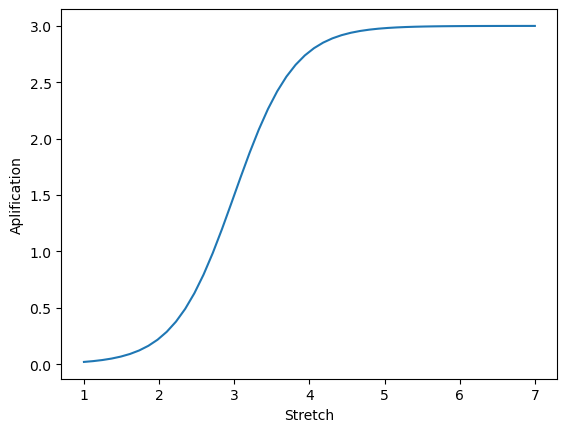

In [3]:
S = np.linspace(1, 7)
plt.plot(S, get_amplification(S))
plt.xlabel('Stretch')
plt.ylabel('Aplification');

Geographic orientation of principal kinematic axes X, Y and Z for deformation $D_2$is given by rotation matrix $R_{D_2}$:

In [4]:
p1 = pair(0, 0, 180, 0)
p2 = pair(220, 11, 196, 10)
RD2 = defgrad.from_two_pairs(p1, p2)

Here we define function to calculate rotation axis and angle of rotation for deformation $D_2$ constrained by stretch $S$:

In [5]:
def getD2(S, y):
    """
    Returns deformation gradient for given position y
    """
    amp = get_amplification(S)
    return defgrad(
        [[1,   0,   0],
         [0,  1/S,  0],
         [0, amp*y, S]]
    )

def random_D2(n, S):
    """
    Returns rotation axis and angle for given stretch S.
    
    Using uniformly random position
    """
    y_rand = 1 - 2*np.random.rand(n)
    return [getD2(S, y).transform(RD2).axisangle() for y in y_rand]

Geographic orientation of principal kinematic axes X, Y and Z for deformation $D_3$is given by rotation matrix $R_{D_3}$:

In [6]:
p1 = pair(0, 90, 90, 0)
p2 = pair(37, 60, 119, 14)
RD3 = defgrad.from_two_pairs(p1, p2)

Here we define function to calculate rotation axis and angle of rotation for deformation $D_3$ constrained by stretch $S$ and simple shear $\gamma$:

In [7]:
def getD3(S, x, gamma):
    """
    Returns deformation gradient for given position x
    """
    amp = get_amplification(S)
    return defgrad(
        [[  1/S,  0, 0],
         [-gamma, 1, 0],
         [ amp*x, 0, S]]
    )

def random_D3(n, S, gamma):
    """
    Returns rotation axis and angle for given stretch S.
    
    Using uniformly random position and lognormal variation of gamma
    """
    x_rand = 1 - 2*np.random.rand(n)
    g_rand = np.random.lognormal(mean=np.log(gamma), sigma=0.3, size=n) if gamma !=0 else np.zeros(n)
    return [getD3(S, x, g).transform(RD3).axisangle() for x, g in zip(x_rand, g_rand)]

Following code snippet demonstrate visual appearence of fold shapes generated by above-given deformation gradient $D_2$

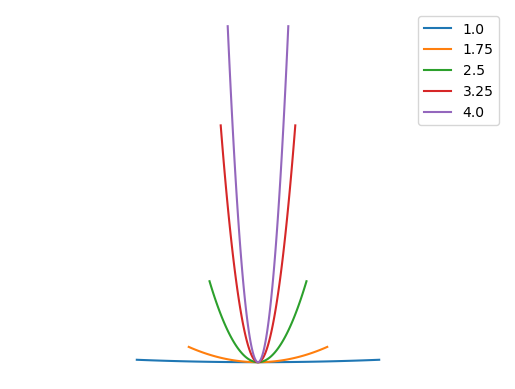

In [8]:
y = np.linspace(-1,1,100)
for S in np.linspace(1, 4, 5):
    v = vecset([vec(0, pos, 0).transform(getD2(S, pos)) for pos in y])
    plt.plot(v.y, v.z, label=S)
plt.legend()
plt.axis('equal')  # no scaling
plt.axis('off');

Following code was used to generate figures published in submitted paper

In [9]:
D3all = [2, 3, 4]  # Three values for stretch S used in model
p = pair()         # Reference orientation of inclusion trails - X - lineation, YZ - foliation
N = 50             # NUmber of individual grains used for simulation. FIA axes are defined fo all pairs of grains

## Pure shear

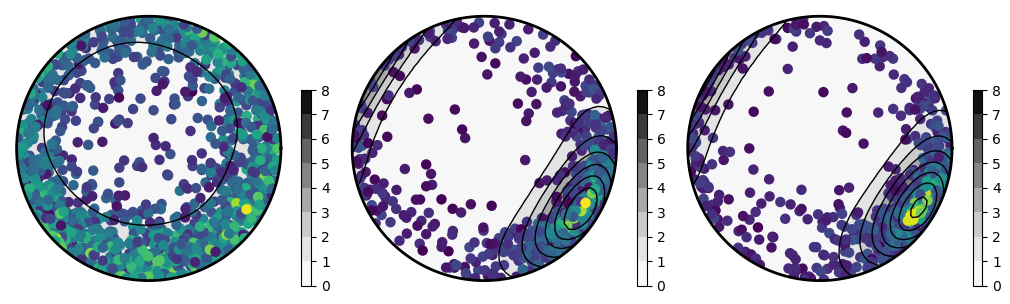

In [10]:
np.random.seed(123456)

fig = plt.figure(constrained_layout=True, figsize=(10, 4))
subfigs = fig.subfigures(1, 3)

for ix, D3 in enumerate(D3all):
    
    # Initial orientation of grains - reference with small noise
    g0 = pairset([p.rotate(vec.random(), 2) for i in range(N)])
    # Re-orientation due to D2
    g1 = pairset([p0.rotate(bos, ang) for p0, (bos, ang) in zip(g0, random_D2(N, S=2))])
    # Re-orientation due to D3: S=[2 3 4],  gamma=0
    g2 = pairset([p1.rotate(bos, ang) for p1, (bos, ang) in zip(g1, random_D3(N, S=D3, gamma=0))])
    
    # Calculate all FIAs
    fia, angs = [], []
    for ix1, ix2 in itertools.combinations(range(N), 2):
        v, ang = defgrad.from_two_pairs(g2[ix1], g2[ix2], symmetry=True).axisangle()
        fia.append(v)
        angs.append(abs(ang))
    fl = vecset(fia).to_lin()
    
    # Plot results
    s = StereoNet(figsize=(10, 10), overlay=False)
    s.contour(fl, sigma=16, colorbar=True, levels=[0,1,2,3,4,5,6,7,8])
    s.scatter(fl, c=angs, num=6)
    s.render2fig(subfigs[ix])

## Simple shear

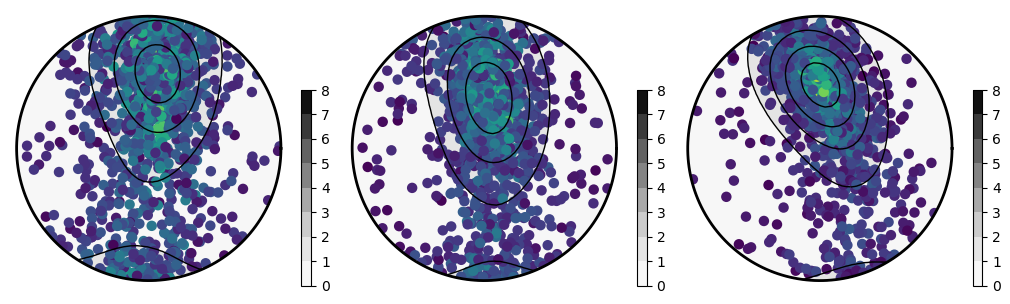

In [11]:
np.random.seed(123456)

fig = plt.figure(constrained_layout=True, figsize=(10, 4))
subfigs = fig.subfigures(1, 3)

for ix, D3 in enumerate(D3all):
    
    # Initial orientation of grains - reference with small noise
    g0 = pairset([p.rotate(vec.random(), 2) for i in range(N)])
    # Re-orientation due to D2
    g1 = pairset([p0.rotate(bos, ang) for p0, (bos, ang) in zip(g0, random_D2(N, S=2))])
    # Re-orientation due to D3: S=1, gamma = (S - 1)/2
    g2 = pairset([p1.rotate(bos, ang) for p1, (bos, ang) in zip(g1, random_D3(N, S=1, gamma=(D3-1)/2))])
    
    # Calculate all FIAs
    fia, angs = [], []
    for ix1, ix2 in itertools.combinations(range(N), 2):
        v, ang = defgrad.from_two_pairs(g2[ix1], g2[ix2], symmetry=True).axisangle()
        fia.append(v)
        angs.append(abs(ang))
    fl = vecset(fia).to_lin()
    
    # Plot results
    s = StereoNet(figsize=(10, 10), overlay=False)
    s.contour(fl, sigma=16, colorbar=True, levels=[0,1,2,3,4,5,6,7,8])
    s.scatter(fl, c=angs, num=6)
    s.render2fig(subfigs[ix])

## Transpression

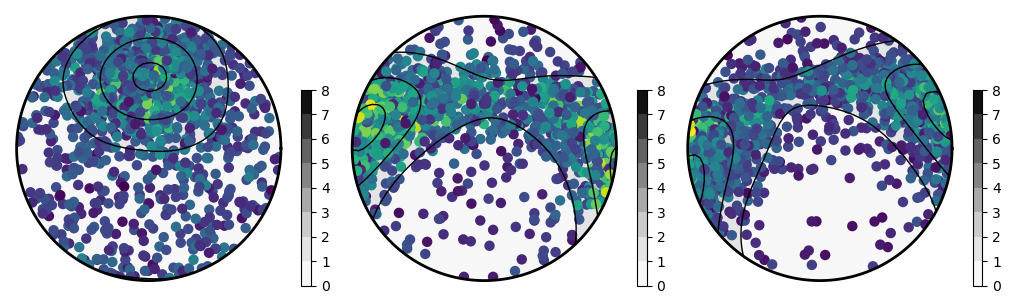

In [12]:
np.random.seed(123456)

fig = plt.figure(constrained_layout=True, figsize=(10, 4))
subfigs = fig.subfigures(1, 3)

for ix, D3 in enumerate(D3all):
    
    # Initial orientation of grains - reference with small noise
    g0 = pairset([p.rotate(vec.random(), 2) for i in range(N)])
    # Re-orientation due to D2
    g1 = pairset([p0.rotate(bos, ang) for p0, (bos, ang) in zip(g0, random_D2(N, S=2))])
    # Re-orientation due to D3: S=[2 3 4], gamma = (S - 1)/2
    g2 = pairset([p1.rotate(bos, ang) for p1, (bos, ang) in zip(g1, random_D3(N, S=D3, gamma=(D3-1)/2))])
    
    # Calculate all FIAs
    fia, angs = [], []
    for ix1, ix2 in itertools.combinations(range(N), 2):
        v, ang = defgrad.from_two_pairs(g2[ix1], g2[ix2], symmetry=True).axisangle()
        fia.append(v)
        angs.append(abs(ang))
    fl = vecset(fia).to_lin()
    
    # Plot results
    s = StereoNet(figsize=(10, 10), overlay=False)
    s.contour(fl, sigma=16, colorbar=True, levels=[0,1,2,3,4,5,6,7,8])
    s.scatter(fl, c=angs, num=6)
    s.render2fig(subfigs[ix])